In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'

# SPEI 0.05deg data

In [2]:
dt=Dataset(spei_path+'spei03.nc')
dt.variables.keys()
spei=dt.variables['spei']
print(spei.shape)
st=np.arange(0,433,12)
st

(432, 1800, 2080)


array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144,
       156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300,
       312, 324, 336, 348, 360, 372, 384, 396, 408, 420, 432])

In [3]:
#1981-2016
#2012:(372,384),2013:(384,396),2014:(396,408),2015:(408,420),2016:(420,432)
#计算2012-2016年均SPEI
st1=np.arange(372,433,12)
print(st1)
spei_dt=np.zeros((5,1800,2080))
for i in range(5):
    spei_dt[i]=np.mean(spei[st1[i]:st1[i+1],:,:],0)
spei_dt.shape

[372 384 396 408 420 432]


(5, 1800, 2080)

# SPEI连续3个月小于-1为drought

In [4]:
dt=Dataset(spei_path+'spei03.nc')
spei=dt.variables['spei']
#2012:(372,384),2013:(384,396),2014:(396,408),2015:(408,420),2016:(420,432)
spei2012_14=spei[372:408,:,:]
spei2015_16=spei[408:432,:,:]
spei_tot=[spei2012_14,spei2015_16]
for i in range(2):
    spei_tot[i][np.isnan(spei_tot[i])]=0
    spei_tot[i][spei_tot[i]>-1]=0
    spei_tot[i][spei_tot[i]<=-1]=1
np.nanmax(spei_tot[0])

1.0

In [5]:
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
spei_ev=np.zeros((2,1800,2080))
for k in range(2):
    dd=np.zeros((34,1800,2080))
    dd1=np.zeros((22,1800,2080))
    if k==0:
        for m in range(34):
            dd[m]=spei_tot[k][m]*spei_tot[k][m+1]*spei_tot[k][m+2] #连续3个月相乘，如果有1出现表示有连续3个月干旱
        spei_ev[k]=np.sum(dd,axis=0)
        spei_ev[k][spei_ev[k]>=1]=1
    if k==1:
        for m in range(22):
            dd1[m]=spei_tot[k][m]*spei_tot[k][m+1]*spei_tot[k][m+2] #连续3个月相乘，如果有1出现表示有连续3个月干旱
        spei_ev[k]=np.sum(dd1,axis=0)
        spei_ev[k][spei_ev[k]>=1]=1
    
spei_afr=spei_ev
print(spei_afr.shape)
spei_afr[np.isnan(spei_afr)]=0
spei_afr15_16=spei_afr[1]
spei_else=spei_afr[0]
#spei_else[spei_else>0]=1
spei1516_only=spei_afr15_16-spei_else
print(np.min(spei1516_only),np.max(spei1516_only))
spei1516_only[spei1516_only==-1]=0

(2, 1800, 2080)
-1.0 1.0


In [6]:
dt_dr=np.zeros((3,1800,2080))
dt_dr[0]=spei_ev[0]
dt_dr[1]=spei_ev[1]
dt_dr[2]=spei1516_only

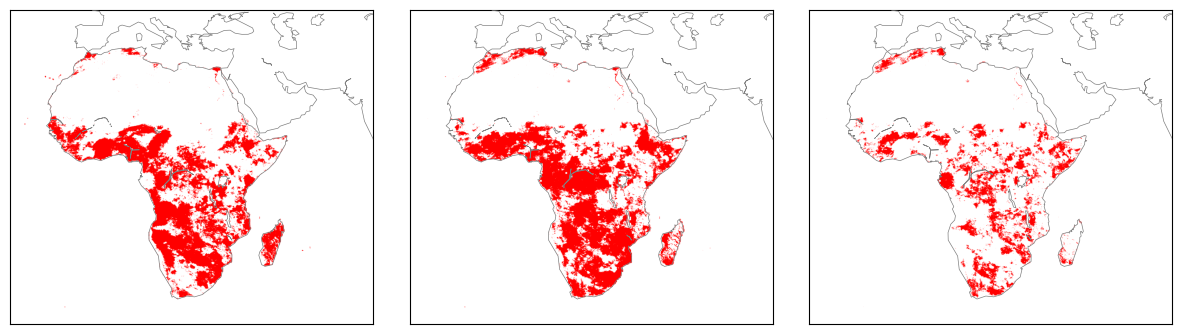

In [7]:
Lon=dt.variables['lon'][:]
Lat=dt.variables['lat'][:]
LonMin,LatMax,LonMax,LatMin = [Lon.min(),Lat.max(),Lon.max(),Lat.min()]
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 1.5) 
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)
lon1 = LonMin;lon2 = LonMax
lat1 = LatMin;lat2 = LatMax
fig = plt.figure(figsize=(15,5)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2)
    #m.drawmapboundary(linewidth=1,fill_color = 'lightcyan')
    m.drawcoastlines(linewidth=0.5, color='gray',zorder=40)
    clist=['white','red']
    cmp=LinearSegmentedColormap.from_list('chaos',clist)
    im = m.imshow(dt_dr[i],cmap =cmp,origin='upper')

#2012-2014年干旱区域，2015-2016年干旱区域，仅2015-2016年干旱区域

In [8]:
from osgeo import gdal, osr, ogr
Lon=dt.variables['lon'][:]
Lat=dt.variables['lat'][:]
LonMin,LatMax,LonMax,LatMin = [Lon.min(),Lat.max(),Lon.max(),Lat.min()]
#分辨率计算
N_Lat = len(Lat)
N_Lon = len(Lon)
Lon_Res = (LonMax - LonMin) /(float(N_Lon)-1)
Lat_Res = (LatMax - LatMin) / (float(N_Lat)-1)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326) # 定义输出的坐标系为"WGS 84"，AUTHORITY["EPSG","4326"]
proj=srs.ExportToWkt()
geotrans = (LonMin, Lon_Res, 0, LatMax, 0, Lat_Res)
write_img(spei_path+'SPEI_drought_spei1516_240504.tif',proj,geotrans,spei1516_only)

In [14]:
#ENVI中resize to 0.01deg
#SPEI_drought_spei1516_001_240504.tif
gdal.Warp(spei_path+'SPEI_drought_spei1516_001sub_240504.tif',
          spei_path+'SPEI_drought_spei1516_001_240504',
          dstSRS='EPSG:4326',
          outputBounds = [-26,-40,53,25],
          xRes=0.01,
          yRes=0.01,
          targetAlignedPixels=True,
          resampleAlg = gdalconst.GRA_NearestNeighbour,
          creationOptions = ["COMPRESS=LZW"])

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001430729BC00> >

# Overlap drought and elephant area

In [9]:
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'
def GetExtent(infile):
    ds = gdal.Open(infile)
    geotrans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    min_x,max_y = geotrans[0],geotrans[3]
    max_x,min_y = geotrans[0]+xsize*geotrans[1],geotrans[3]+ysize*geotrans[5]
    ds = None
    return min_x,max_y,max_x,min_y
tt=GetExtent(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')
tt

(-26.0, 25.0, 53.0, -40.0)

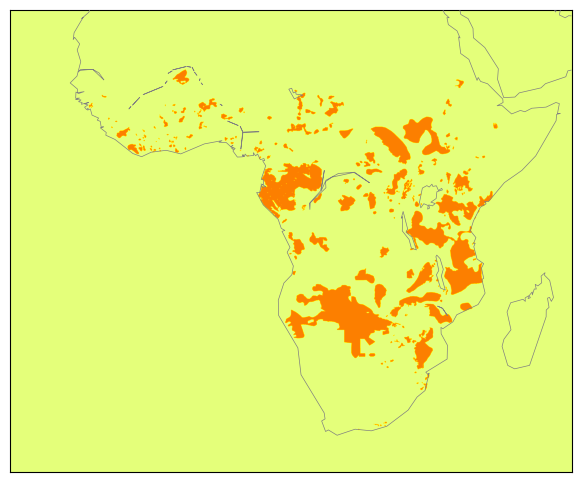

In [10]:
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
fig = plt.figure(figsize=(8,6))
m = Basemap(llcrnrlon=tt[0],llcrnrlat=tt[3],urcrnrlon=tt[2],urcrnrlat=tt[1])
m.drawcoastlines(linewidth=0.5, color='gray',zorder=40)
im = m.imshow(ele,vmin=0, vmax = 1, cmap ='Wistia',origin='upper')#

In [11]:
drought=read_img(spei_path+'SPEI_drought_spei1516_001sub_240504.tif')[0]
np.min(drought),np.max(drought)

(0.0, 1.0)

In [12]:
dt=read_img(spei_path+'SPEI_drought_spei1516_001sub_240504.tif')
ele[ele>0]=1
DEAA=drought*ele
DAA=drought-DEAA
write_img(spei_path+'SPEI_deaa001_240504.tif',dt[4],dt[3],DEAA)
write_img(spei_path+'SPEI_daa001_240504.tif',dt[4],dt[3],DAA)

<Figure size 800x600 with 0 Axes>

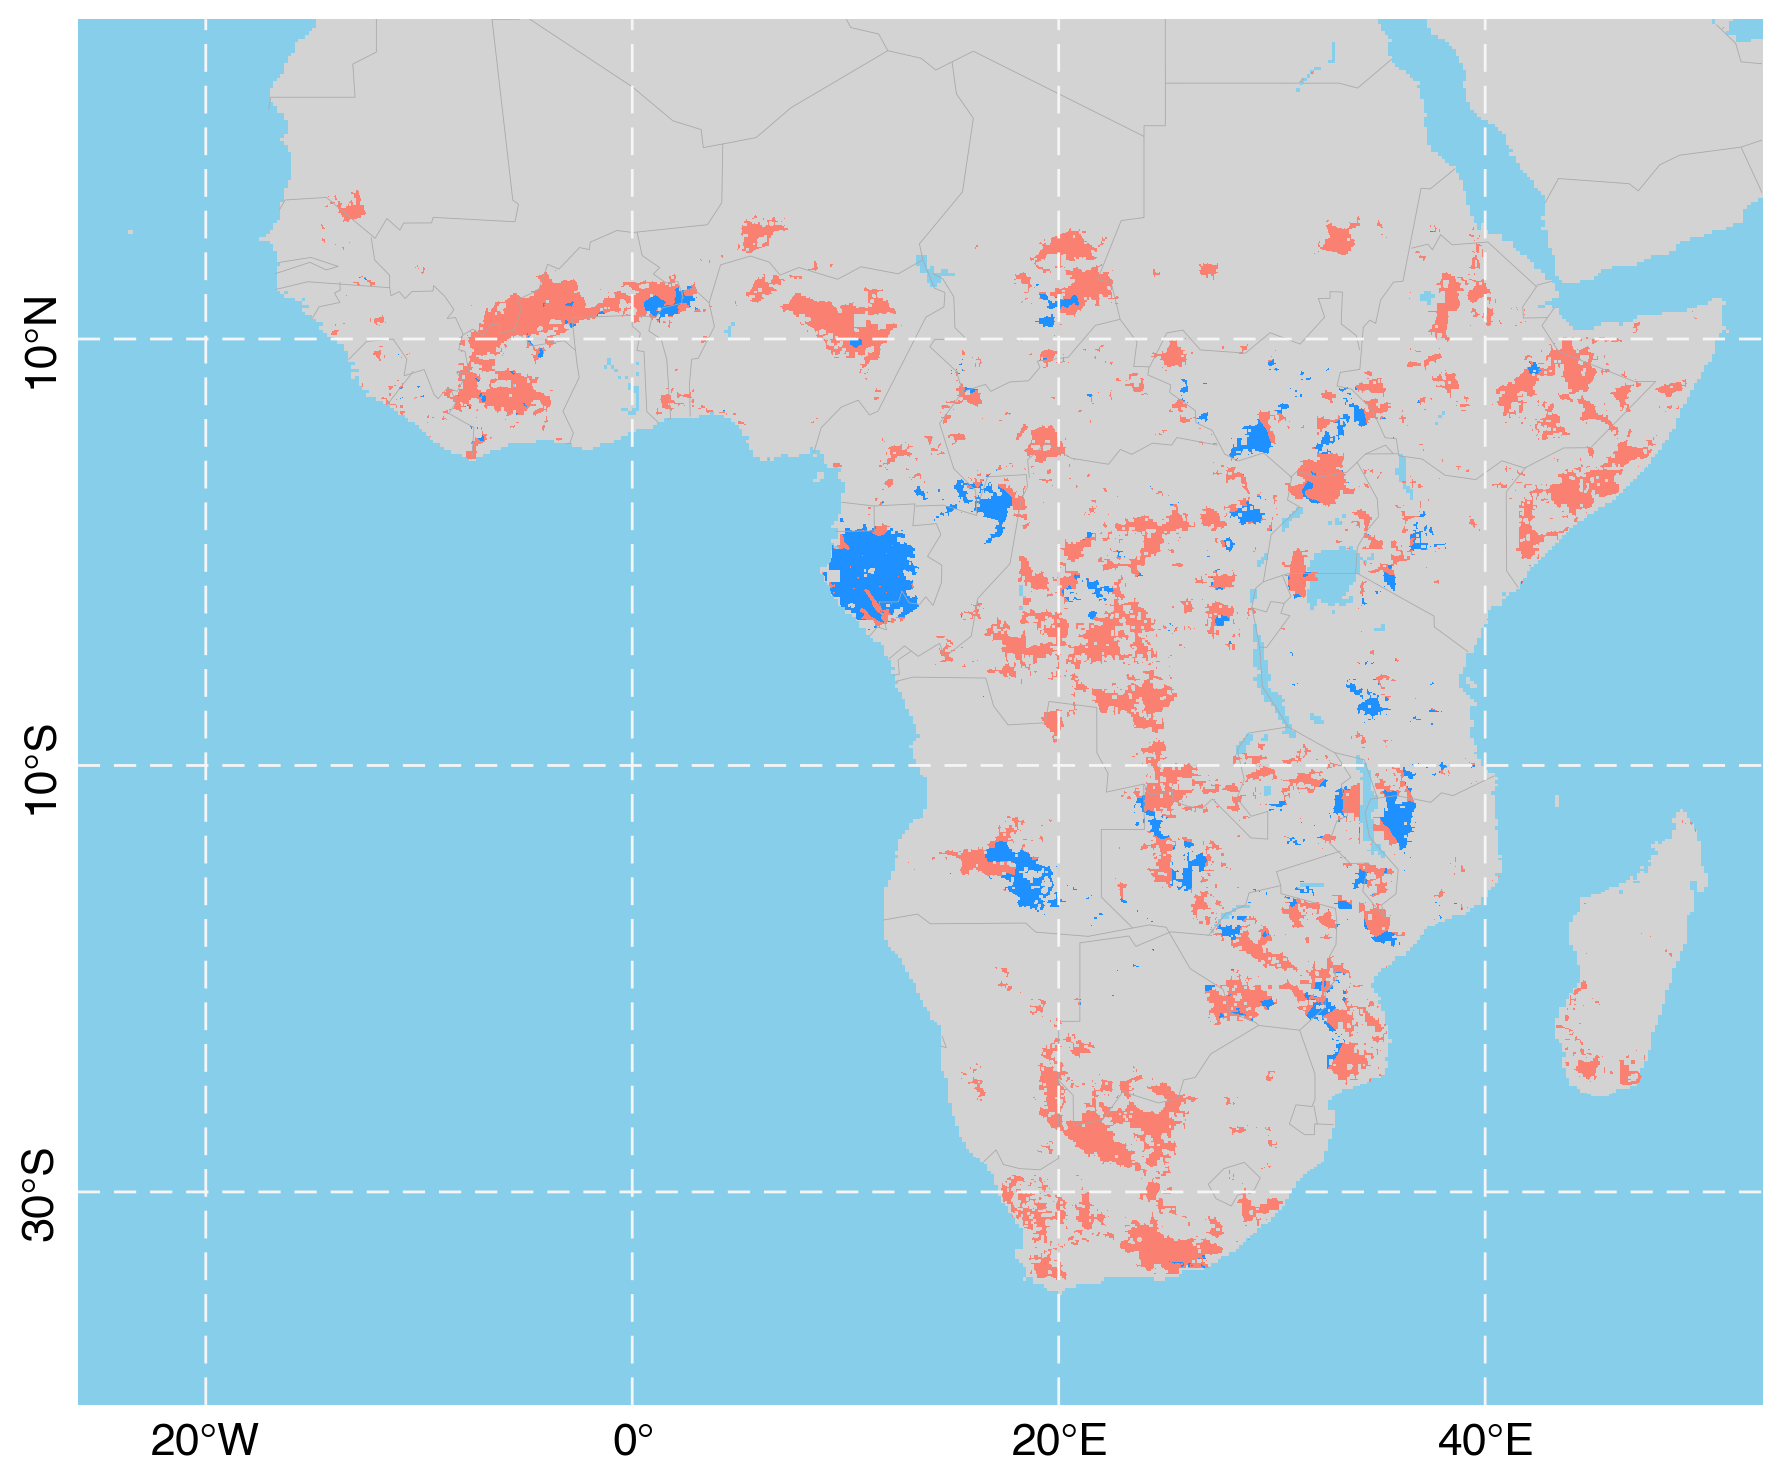

In [13]:
DEAA[DEAA==1]=2
D_show=DAA+DEAA
D_show[D_show==0]=np.nan

fig = plt.figure(figsize=(8,6))
from matplotlib import colors
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 1.5) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,9), sharex=True,sharey=True)

m = Basemap(llcrnrlon=-26,llcrnrlat=-40,urcrnrlon=53,urcrnrlat=25,ax=axs)
m.drawlsmask(land_color='lightgray',ocean_color='skyblue',lakes=True)
m.drawcountries(linewidth=0.30, color='darkgrey')
drawparallels=m.drawparallels(np.arange(-90,90,20),labels=[1,0,0,1],dashes=[8,5],color='whitesmoke',fontsize=16)
for i in range(3):
    drawparallels[list(drawparallels.keys())[i]][1][0].set_rotation(90)#垂直显示经度标签
m.drawmeridians(np.arange(-180,180,20),labels=[1,0,0,1],dashes=[10,5],color='whitesmoke',fontsize=16)#dashes[1,1]表示1 pixel on, 1 pixel off
cmap0=colors.ListedColormap(['salmon','dodgerblue'])#设置离散cmap
plot_normalizer = matplotlib.colors.Normalize(vmin = 1.0, vmax = 2.0, clip = True)
im = m.imshow(D_show, cmap =cmap0,norm = plot_normalizer,origin='upper')
#axs.legend(im,label='Drought area')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

# fig paired sites

In [43]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

In [44]:
DEAA.shape

(6500, 7900)

In [55]:
f1=np.load(spei_path+'Resistance_DEAA_ndvi_res_0.25deg_240504.npy',allow_pickle=True)
f2=np.load(spei_path+'Resistance_DAA_ndvi_res_0.25deg_240504.npy',allow_pickle=True)
ff=(f1-f2)
np.count_nonzero(~np.isnan(ff))
mm=np.copy(ff)
mm[~np.isnan(mm)]=1

In [61]:
deaa_1=np.copy(DEAA)
daa_1=np.copy(DAA)
s=25
for i in range(260):
    for j in range(316):
        if mm[i,j]!=1:
            deaa_1[i*s:(i+1)*s,j*s:(j+1)*s]=np.zeros((s,s))
            daa_1[i*s:(i+1)*s,j*s:(j+1)*s]=np.zeros((s,s))
deaa_1[deaa_1==0]=np.nan
daa_1[daa_1==0]=np.nan

In [62]:
dt=read_img(spei_path+'SPEI_deaa001_240504.tif')
write_img(spei_path+'mask_deaa_240722.tif',dt[4],dt[3],deaa_1)
write_img(spei_path+'mask_daa_240722.tif',dt[4],dt[3],daa_1)

<Figure size 800x600 with 0 Axes>

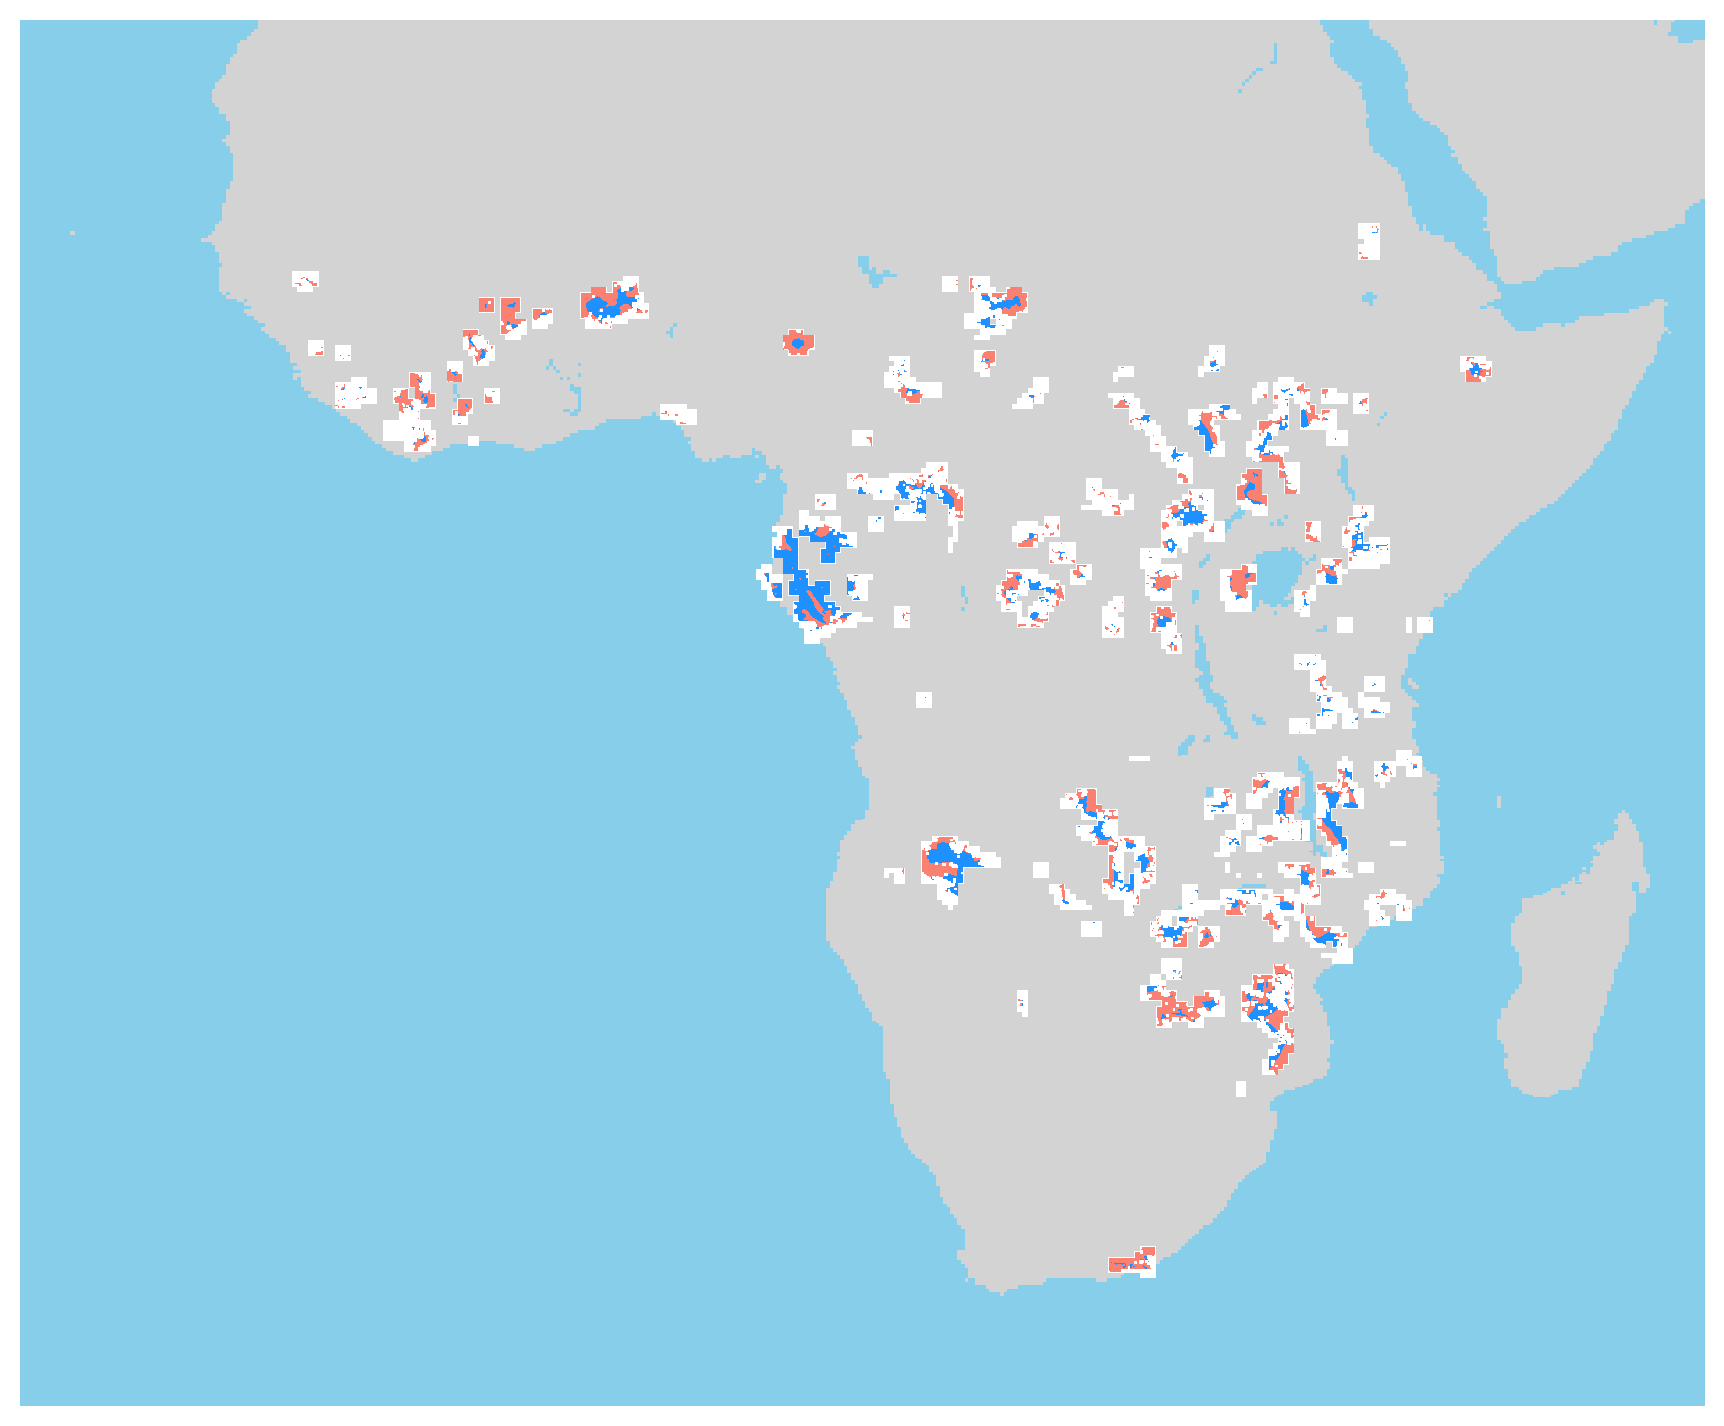

In [68]:
deaa_1[np.isnan(deaa_1)]=0
daa_1[np.isnan(daa_1)]=0

deaa_1[deaa_1==1]=2
D_show=daa_1+deaa_1
D_show[D_show==0]=np.nan

fig = plt.figure(figsize=(8,6))
from matplotlib import colors
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 1.5) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,9), sharex=True,sharey=True)

m = Basemap(llcrnrlon=-26,llcrnrlat=-40,urcrnrlon=53,urcrnrlat=25,ax=axs)
m.drawlsmask(land_color='lightgray',ocean_color='skyblue',lakes=True)
#m.drawcountries(linewidth=0.30, color='darkgrey')
#m.drawmeridians(np.arange(-180,180,20),labels=[1,0,0,1],dashes=[10,5],color='whitesmoke',fontsize=16)#dashes[1,1]表示1 pixel on, 1 pixel off
cmap0=colors.ListedColormap(['salmon','dodgerblue'])#设置离散cmap
cmap1=colors.ListedColormap(['white'])#设置离散cmap
plot_normalizer = matplotlib.colors.Normalize(vmin = 1.0, vmax = 2.0, clip = True)
im = m.imshow(D_show, cmap =cmap0,norm = plot_normalizer,origin='upper',zorder=10)
im1 = m.imshow(mm, cmap =cmap1,norm = plot_normalizer,origin='upper')
#axs.legend(im,label='Drought area')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

# 区分LA,LC

In [24]:
LA=read_img(spei_path+'LA_extant_001_240320.tif')[0]
LC=read_img(spei_path+'LC_extant_001_240320.tif')[0]
drought=read_img(spei_path+'SPEI_drought_spei1516_001sub_240504.tif')[0]
LA_da=LA*drought
LC_da=LC*drought
print(np.nanmin(LA_da),np.nanmax(LC_da))
dt=read_img(spei_path+'LA_extant_001_240320.tif')
write_img(spei_path+'LA_extant_drought_001_240504.tif',dt[4],dt[3],LA_da)
write_img(spei_path+'LC_extant_drought_001_240504.tif',dt[4],dt[3],LC_da)

0.0 1.0
